<a href="https://colab.research.google.com/github/MaelleCornec/random_teachers/blob/main/master_ia_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialisation du notebook

Il faut bien penser à activer le GPU pour aller plus vite

In [1]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [2]:
##########################
### SETTINGS
##########################

# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.001
BATCH_SIZE = 128
# changer ça en fonction des expériences:
NUM_EPOCHS = 20

# Architecture
NUM_FEATURES = 28*28
NUM_CLASSES = 10

# Other
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
GRAYSCALE = False

print(f"Device utilisé: {DEVICE}")

Device utilisé: cpu


In [3]:
##########################
### MNIST DATASET
##########################

# Note transforms.ToTensor() scales input images
# to 0-1 range
train_dataset = datasets.CIFAR10(root='data',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.CIFAR10(root='data',
                              train=False,
                              transform=transforms.ToTensor())


train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

100%|██████████| 170498071/170498071 [00:09<00:00, 18688815.99it/s]


Extracting data/cifar-10-python.tar.gz to data
Image batch dimensions: torch.Size([128, 3, 32, 32])
Image label dimensions: torch.Size([128])


On vérifie que les batchs sont bien initialisés

In [4]:
device = torch.device(DEVICE)
torch.manual_seed(0)

for epoch in range(2):

    for batch_idx, (x, y) in enumerate(train_loader):

        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])

        x = x.to(device)
        y = y.to(device)
        break

Epoch: 1 | Batch index: 0 | Batch size: 128
Epoch: 2 | Batch index: 0 | Batch size: 128


8


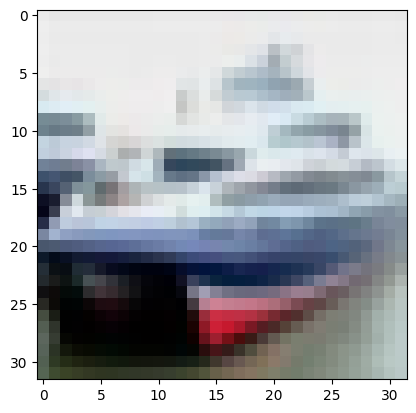

In [5]:
for batch_idx, (features, targets) in enumerate(test_loader):

    features = features
    targets = targets
    break

nhwc_img = np.transpose(features[1], axes=(1, 2, 0))
nhw_img = nhwc_img.numpy()
plt.imshow(nhw_img)
print(targets[1].item())


# Définition des modèles

## ResNet18

In [6]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # because MNIST is already 1x1 here:
        # disable avg pooling
        #x = self.avgpool(x)

        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas



def resnet18(num_classes):
    """Constructs a ResNet-18 model."""
    model = ResNet(block=BasicBlock,
                   layers=[2, 2, 2, 2],
                   num_classes=NUM_CLASSES,
                   grayscale=GRAYSCALE)
    return model

## VGG

à rajouter

# Entrainement des modèles

In [7]:
def compute_accuracy(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):

        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

In [8]:
def update_student_parameters(teacher, student, alpha):
    alpha_tensor = torch.tensor(alpha, dtype=torch.float32)  # Convert alpha to a tensor
    delta = torch.sqrt(alpha_tensor**2 + (1 - alpha_tensor)**2)
    for param_teacher, param_student in zip(teacher.parameters(), student.parameters()):
        fresh_init = torch.randn_like(param_student.data)  # Fresh initialization
        new_param_student = (1 - alpha_tensor) * param_teacher.data + alpha_tensor * fresh_init
        new_param_student /= delta
        param_student.data.copy_(new_param_student)


## Entrainement non-naif du teacher (ne reproduit pas une figure ou résultat du papier)

On entraine une première fois un modèle, histoire de vérifier que tout fonctionne. Il jouera le rôle de teacher, dans l'idée il faudra initialiser le teacher aléatoirement

In [9]:
def test_algo():
    torch.manual_seed(RANDOM_SEED +1)

    model = resnet18(NUM_CLASSES)
    model.to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    start_time = time.time()
    for epoch in range(1):

        model.train()
        for batch_idx, (features, targets) in enumerate(train_loader):

            features = features.to(DEVICE)
            targets = targets.to(DEVICE)

            ### FORWARD AND BACK PROP
            logits, probas = model(features)
            cost = F.cross_entropy(logits, targets)
            optimizer.zero_grad()

            cost.backward()

            ### UPDATE MODEL PARAMETERS
            optimizer.step()

            ### LOGGING
            if not batch_idx % 50:
                print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f'
                      %(epoch+1, NUM_EPOCHS, batch_idx,
                        len(train_loader), cost))

        model.eval()
        with torch.set_grad_enabled(False): # save memory during inference
            print('Epoch: %03d/%03d | Train: %.3f%%' % (
                  epoch+1, NUM_EPOCHS,
                  compute_accuracy(model, train_loader, device=DEVICE)))

        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

#test_algo()

## Reproduction Fig.1

### Proposition distance : MSE

Le teacher n'est pas randomisé à chaque epoch, pas de linear probing non plus

In [10]:
def train_knowledge_distillation_mse(teacher, student, train_loader, epochs, learning_rate, device):
    optimizer = torch.optim.Adam(student.parameters(), lr=learning_rate)

    teacher.eval()  # L'enseignant ne va pas être actualisé
    start_time = time.time()

    for epoch in range(epochs):

      student.train() # On va actualiser l'étudiant

      for batch_idx, (features, targets) in enumerate(train_loader):
          features = features.to(DEVICE)
          targets = targets.to(DEVICE)

          ## Forward pass avec l'enseignant et l'étudiant
          with torch.no_grad():
              teacher_logits, _ = teacher(features)
          student_logits, _ = student(features)

          # La distance est calculée par Mean Squared Error (pas défini dans l'article)
          loss_distillation = F.mse_loss(student_logits, teacher_logits)
          # si on veut définir une loss plus complexe, il suffirait de la plug-in ci-dessous
          loss = loss_distillation

          optimizer.zero_grad()

          ## Backpropagation
          loss.backward()

          ## Update les paramètres du modèle
          optimizer.step()

          ## Log des résultats
          if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f'
                   %(epoch+1, epochs, batch_idx,
                    len(train_loader), loss))
      student.eval()
      with torch.set_grad_enabled(False): # save memory during inference
          print('Epoch: %03d/%03d | Train: %.3f%%' % (
                epoch+1, epochs,
                compute_accuracy(student, train_loader, device=device)))

      print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

In [11]:
teacher = resnet18(NUM_CLASSES)
teacher.to(DEVICE)
student = resnet18(NUM_CLASSES)
student.to(DEVICE)

print("ok")

# train_knowledge_distillation_mse(teacher, student, train_loader, NUM_EPOCHS, LEARNING_RATE, DEVICE)

ok


In [ ]:
# student.eval()
# with torch.set_grad_enabled(False):
#   print("%.3f% %" % compute_accuracy(teacher, train_loader, device=device))

### Proposition distance: KL divergence

pas (encore) de teacher randomisé à chaque epoch, KL divergence et linear probing

In [12]:
import torch
import torch.nn.functional as F
import time
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

def train_knowledge_distillation_kl_linear_probing_LR(model,
                                                   train_loader,
                                                   epochs,
                                                   learning_rate,
                                                   device,
                                                    alpha,
                                                   epoch_randomized_teacher = False,
                                                  ):
    ### Definition des modèles initiaux
    teacher = model(NUM_CLASSES)
    teacher.to(DEVICE)
    student = model(NUM_CLASSES)
    student.to(DEVICE)

    update_student_parameters(teacher, student, alpha=alpha)

    # Definition des variables/comportement des objets
    optimizer = torch.optim.Adam(student.parameters(), lr=learning_rate)
    teacher.eval()
    start_time = time.time()
    logistic_regression_kwarg = {
        "max_iter" : 1000,
        "random_state" : 0,
    }

    ### Definition loggers
    teacher_accuracy_log = []
    student_accuracy_log = []

    for epoch in range(epochs):

        if epoch_randomized_teacher:
            teacher = model(NUM_CLASSES)
            teacher.to(DEVICE)
            teacher.eval()

        student.train()
        teacher_logits_list = []
        student_logits_list = []
        targets_list = []

        for batch_idx, (features, targets) in enumerate(train_loader):
            features = features.to(device)
            targets = targets.to(device)

            with torch.no_grad():
                teacher_logits, _ = teacher(features)
            student_logits, _ = student(features)

            teacher_logits_list.append(teacher_logits.cpu().detach().numpy())
            student_logits_list.append(student_logits.cpu().detach().numpy())
            targets_list.append(targets.cpu().detach().numpy())

            loss_distillation = F.kl_div(F.log_softmax(student_logits, dim=1),
                                          F.softmax(teacher_logits, dim=1),
                                          reduction='batchmean')
            loss = loss_distillation

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if not batch_idx % 50:
                print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f'
                       %(epoch+1, epochs, batch_idx,
                        len(train_loader), loss.item()))

        # On convertit les tenseurs pour permettre de concaténer les batchs
        teacher_logits_tensor = torch.from_numpy(np.concatenate(teacher_logits_list, axis=0))
        student_logits_tensor = torch.from_numpy(np.concatenate(student_logits_list, axis=0))
        targets_tensor = torch.from_numpy(np.concatenate(targets_list, axis=0))

        # Ensuite on fit la logistic regression sur les logits du teacher
        logistic_regression_teacher = LogisticRegression(**logistic_regression_kwarg)
        logistic_regression_teacher.fit(teacher_logits_tensor, targets_tensor)
        teacher_accuracy = accuracy_score(targets_tensor, logistic_regression_teacher.predict(teacher_logits_tensor))
        print(f'Epoch: {epoch+1}/{epochs} | Teacher Logistic Regression Accuracy: {teacher_accuracy:.3f}')

        # Ensuite on fit la logistic regression sur les logits du student
        logistic_regression_student = LogisticRegression(**logistic_regression_kwarg)
        logistic_regression_student.fit(student_logits_tensor, targets_tensor)
        student_accuracy = accuracy_score(targets_tensor, logistic_regression_student.predict(student_logits_tensor))
        print(f'Epoch: {epoch+1}/{epochs} | Student Logistic Regression Accuracy: {student_accuracy:.3f}')
        student_accuracy_log.append(student_accuracy)
        teacher_accuracy_log.append(teacher_accuracy)
        # Evaluate student
        student.eval()
        with torch.set_grad_enabled(False):
            print('Epoch: %03d/%03d | Train: %.3f%%' % (
                    epoch+1, epochs,
                    compute_accuracy(student, train_loader, device=device)))

        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
    return teacher_accuracy_log, student_accuracy_log

In [ ]:
print("ok")
teacher_accuracy_log, student_accuracy_log = train_knowledge_distillation_kl_linear_probing_LR(resnet18,
                                                                                            train_loader,
                                                                                            NUM_EPOCHS,                                                                                     LEARNING_RATE,
                                                                                            DEVICE,
                                                                                            alpha = 0.1,
                                                                                            epoch_randomized_teacher = True,
)

ok
Epoch: 001/020 | Batch 0000/0391 | Cost: 2.6653
Epoch: 001/020 | Batch 0050/0391 | Cost: 0.1520
Epoch: 001/020 | Batch 0100/0391 | Cost: 0.0280
Epoch: 001/020 | Batch 0150/0391 | Cost: 0.0162
Epoch: 001/020 | Batch 0200/0391 | Cost: 0.0081
Epoch: 001/020 | Batch 0250/0391 | Cost: 0.0080
Epoch: 001/020 | Batch 0300/0391 | Cost: 0.0052
Epoch: 001/020 | Batch 0350/0391 | Cost: 0.0049
Epoch: 1/20 | Teacher Logistic Regression Accuracy: 0.245
Epoch: 1/20 | Student Logistic Regression Accuracy: 0.142
Epoch: 001/020 | Train: 9.764%
Time elapsed: 17.50 min
Epoch: 002/020 | Batch 0000/0391 | Cost: 0.0228
Epoch: 002/020 | Batch 0050/0391 | Cost: 0.0050
Epoch: 002/020 | Batch 0100/0391 | Cost: 0.0035
Epoch: 002/020 | Batch 0150/0391 | Cost: 0.0025
Epoch: 002/020 | Batch 0200/0391 | Cost: 0.0017
Epoch: 002/020 | Batch 0250/0391 | Cost: 0.0027
Epoch: 002/020 | Batch 0300/0391 | Cost: 0.0021
Epoch: 002/020 | Batch 0350/0391 | Cost: 0.0018
Epoch: 2/20 | Teacher Logistic Regression Accuracy: 0.235


In [ ]:
teacher_accuracy_log, student_accuracy_log

### LR sur données complètes

In [ ]:
def flatten_loader(loader):
    features_list = []
    targets_list = []
    for batch_features, batch_targets in loader:
        features_list.append(batch_features.view(batch_features.size(0), -1))
        targets_list.append(batch_targets)
    return torch.cat(features_list, dim=0), torch.cat(targets_list, dim=0)

# Flatten the train_loader
flattened_features, flattened_targets = flatten_loader(train_loader)

# Fit logistic regression on flattened data
logistic_regression = LogisticRegression(max_iter=100, random_state=0)
logistic_regression.fit(flattened_features.numpy(), flattened_targets.numpy())

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=0)

In [ ]:
flattened_features, flattened_targets = flatten_loader(test_loader)
accuracy_score(flattened_targets, logistic_regression.predict(flattened_features))


0.4051

## Autre expérience (à compléter)